# City Affordability & Happiness Analysis

## Introduction/Business Problem

As a young professional on the job market, I have recently realized the huge discrepancy in housing prices for cities around the United States.  Typically, the markets with the higher housing costs are also the markets with the higher salaries.  I would like to filter through the data to find which cities I would best be able to buy a house.  It is important to note that salary vs. housing cost is not the only factor considered to find the best cities to move to; happiness is probably the most important factor when looking for a place to move. <br/> <br/>
The goal of this project is to build a notebook that helps the user rank potential places to live.  The intended user is anyone who is looking to move to a city within the United States. <br/> <br/>
Inherently, some very important factors will be left out of this analysis.  For example, where family and friends live is not taken into account.  The local school system is another major factor not considered in this analysis which many users would consider crucial.

## Data

The data used will be coming from three main sources:<br><br>
<strong>Zillow:<strong/>
- Smoothed, seasonally adjusted measure of the typical home value and market changes
- Typical value for homes within the 65th to 95th percentile range
- All single-family residences and for all homes with 1, 2, 3, 4 and 5+ bedrooms

Download can be found [here](https://www.zillow.com/research/data/)


<strong>U.S. Bureau of Economic Analysis:<strong/>
- Income data is counted per person over 18 years old
- Income that people get from wages, proprietors' income, dividends, interest, rents, and government benefits
- A person's income is counted in the county, metropolitan statistical area, or other area where they live, even if they work elsewhere.

Download can be found [here](https://www.bea.gov/data/income-saving/personal-income-county-metro-and-other-areas)


<strong>Foursquare:<strong/>
- Data is pulled from Foursquare to better understand cities
- The number of venues in a city is taken in a 5 mile radius from city center


In [376]:
# Import libraries
import time
import pandas as pd
import numpy as np
import folium
import matplotlib as mpl
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans 
from sklearn.datasets.samples_generator import make_blobs 
from sklearn.cluster import SpectralClustering
import requests
from pandas.io.json import json_normalize

In [377]:
# Import files for analysis
df_housing_all = pd.read_csv('Housing_Prices.csv')
df_income_all = pd.read_csv('Income_Data.csv', skiprows = 4)
df_cities_all = pd.read_csv('City_Locations.csv')

In [378]:
# Clean the housing prices file

# Keep only relavent columns
df_housing_col = df_housing_all[['RegionName','StateName','5/31/2020']]
# Remove NaN values
df_housing_on = df_housing_col[df_housing_col['StateName'] == df_housing_col['StateName']]
#Rename columns
df_housing = df_housing_on.rename(columns={"RegionName": "City", "StateName": "State", "5/31/2020": "Price"})

In [379]:
# Clean the income file

# Keep only relavent columns
df_income_col = df_income_all[['Metropolitan Statistical Areas2','Unnamed: 3']]
# Remove NaN values
df_income_on = df_income_col[df_income_col['Unnamed: 3'] == df_income_col['Unnamed: 3']]
#Rename columns
df_income = df_income_on.rename(columns={"Metropolitan Statistical Areas2": "City", "Unnamed: 3": "Income"})
df_income["Income"] = df_income["Income"].replace(',','',regex=True)
df_income["Income"] = df_income["Income"].astype('int64')

In [380]:
# Clean location data file

#Set US State conversions to follow 'City, ST' convention
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}
df_cities_all['abbrev'] = df_cities_all.State.replace(us_state_abbrev)
df_cities_all['City'] = df_cities_all[['City', 'abbrev']].apply(lambda x: ', '.join(x), axis=1)
# Keep only relavent columns
df_cities = df_cities_all[['City', 'Latitude', 'Longitude']]

In [381]:
# Merge Files Together
df = pd.merge(df_housing,df_income,on='City', how='inner')
df_2 = pd.merge(df,df_cities,on='City', how='inner')

# Remove state from city
df['City'] = df['City'].str[:-4]
df_2['City'] = df_2['City'].str[:-4]
df_2noak = df_2[df_2['State'] != 'AK']

In [382]:
# Plot all points with a location

#create a map
this_map = folium.Map(width=1000,height=500,prefer_canvas=True)

def plotDot(point):
    pp = folium.Popup(point.City,parse_html=True,)
    folium.CircleMarker(location=[point.Latitude, point.Longitude],
                        radius=3, popup=pp).add_to(this_map)

df_2noak.apply(plotDot, axis = 1)

#Set the zoom to the maximum possible
this_map.fit_bounds(this_map.get_bounds())
this_map

The location data looks like a good representation of the US population as a whole.  Some cities were not included in the figure above but will be used whenever possible in this analysis. This map only shows cities within the contiguous United States.  Cities in Alaska and Hawaii are included in the rest of the analysis where permissible.

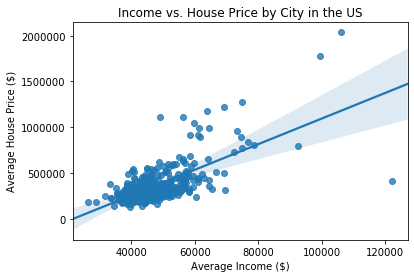

In [383]:
fig = sns.regplot("Income", "Price", df)
plt.xlabel("Average Income ($)")
plt.ylabel("Average House Price ($)")
plt.title("Income vs. House Price by City in the US")
plt.show(fig)

As expected, we can see that House Price and Income are positively correlated.  Additionally, we can see a few groups of data that can be clustered together.

We will go forward with K-Means to group cities together in the above plot.

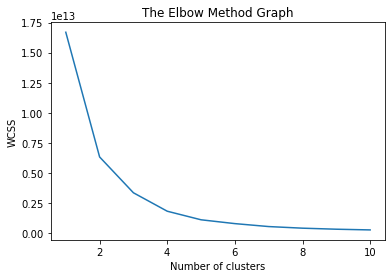

In [384]:
#Start with the elbow method to find the best number of clusters.

X = df[["Income", "Price"]]
wcss=[]
for i in range(1,11): 
    kmeans = KMeans(n_clusters=i, init ='k-means++', max_iter=300,  n_init=10,random_state=0 )
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11),wcss)
plt.title('The Elbow Method Graph')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show() 

I have chosen to use 4 clusters going forward.  The elbow is not completely clear, but I would prefer to split the data into too many groups rather than too few.

In [385]:
kmeans = KMeans(n_clusters=4, init ='k-means++', max_iter=300, n_init=20,random_state=0 )
y_kmeans = kmeans.fit_predict(X)
df["group"] = y_kmeans

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


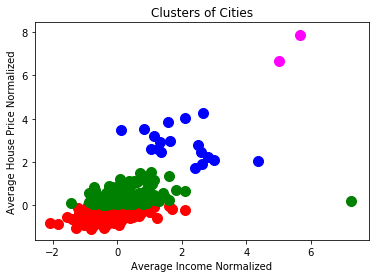

In [386]:
def std_norm(df, column):
    c = df[column]
    df[column] = (c - c.mean())/c.std()
    return df

X = std_norm(X, "Price")
X = std_norm(X, "Income")

X = np.array(X)
plt.scatter(X[y_kmeans==0, 0], X[y_kmeans==0, 1], s=100, c='red', label ='Cluster 1')
plt.scatter(X[y_kmeans==1, 0], X[y_kmeans==1, 1], s=100, c='blue', label ='Cluster 2')
plt.scatter(X[y_kmeans==2, 0], X[y_kmeans==2, 1], s=100, c='green', label ='Cluster 3')
plt.scatter(X[y_kmeans==3, 0], X[y_kmeans==3, 1], s=100, c='magenta', label ='Cluster 4')
#plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='yellow', label = 'Centroids')
plt.title('Clusters of Cities')
plt.xlabel('Average Income Normalized')
plt.ylabel('Average House Price Normalized')
plt.show()

The data has been broken down into 4 groups.<br><br>
We will call the groups:
- Low (Red)
- Medium (Green)
- High (Blue)
- Luxury (Pink)

In [387]:
# Create a dataframe for each group

df_low = df[df["group"] == 0]
df_med = df[df["group"] == 2]
df_high = df[df["group"] == 1]
df_lux = df[df["group"] == 3]

If we want to look at which cities fall into the luxury categories, we can:

In [388]:
df_lux.reset_index(drop = True, inplace = True)
df_lux

,City,State,Price,Income,group
0,San Francisco,CA,1779899,99424,3
1,San Jose,CA,2036828,106213,3


This analysis groups cities that are similar to each other in terms of salary and housing prices.  Both cities are in the bay area and have extremely high living costs and incomes.  But is the amount of income increase enough to help you afford a house?<br><br>
It appears obvious that some of the outliers on the right side of the plot (high income, low housing cost) would be ideal, but they are not highlighted using the current method.<br><br>
We will need to create a new metric to compare income and housing prices directly.

In [389]:
# Set a ratio between income and housing price
df["ratio"] = df["Income"]/df["Price"]
# Normalize the ratio to std dev
std_norm(df, "ratio")
# Sort the data to show the most affordable cities
result = df.sort_values(by = ["ratio"], ascending = False)
result.head(20)

,City,State,Price,Income,group,ratio
359,Danville,IL,127046,39481,0,3.486525
267,Midland,TX,407719,122247,2,3.248685
264,Johnstown,PA,144861,43420,0,3.246598
321,Decatur,IL,166446,48214,0,3.027512
181,Charleston,WV,169102,44053,0,2.393062
354,Midland,MI,236531,60467,0,2.287078
351,Elmira,NY,177823,44373,0,2.154203
334,Pine Bluff,AR,141006,34554,0,2.056689
329,Cumberland,MD,164125,40049,0,2.034098
297,Beckley,WV,158903,38717,0,2.026190


The data is heavily skewed to cities in the "low" housing cost and income ranges meaning that these cities can be considered more affordable to the average American.<br><br>
The issue with this analysis is that it ignores the type of jobs available in each city.<br><br>
Because I am looking for an engineering job in which I can grow, I will consider cities outside of the 'low' group.  Good jobs do exist in these cities but they would be harder to come across.

In [390]:
# Remove cities in the 'low' group
result = result[result["group"] != 0]
result.reset_index(drop = True, inplace = True)

Now we will look at the most affordable cities in America:

In [391]:
result = result.sort_values(by = ["ratio"], ascending = False)
result.reset_index(drop = True, inplace = True)
result[["City","State"]].head(10)

,City,State
0,Midland,TX
1,Philadelphia,PA
2,Chicago,IL
3,Houston,TX
4,Richmond,VA
5,Rochester,MN
6,Bismarck,ND
7,Minneapolis,MN
8,Manchester,NH
9,Lancaster,PA


And the least:

In [392]:
result = result.sort_values(by = ["ratio"], ascending = True)
result.reset_index(drop = True, inplace = True)
result[["City","State"]].head(10)

,City,State
0,Kahului,HI
1,Salinas,CA
2,San Jose,CA
3,Los Angeles,CA
4,San Francisco,CA
5,Santa Cruz,CA
6,Urban Honolulu,HI
7,Napa,CA
8,San Diego,CA
9,San Luis Obispo,CA


From the analysis, it appears that Midland, TX would be the best city to move to and I should avoid California.  As someone who has lived in Midland, TX, I can verify that it is a great place in terms of income and affordability.  However, the city was not a good fit in terms of what I was looking for.<br><br>
At this point, we need to note that there is no single "perfect" city.  Everyone will have their own preferences when it comes to where they live.  So how can we account for this?<br><br>
I will attempt to use the Foursquare API to find cities that have a high level of activities for residents.

In [393]:
foursquare_API = pd.read_csv("Foursquare_API.csv", index_col = "Parameter")
api_id = foursquare_API['Value'].values[0]
api_pwd = foursquare_API['Value'].values[1]
api_ver = foursquare_API['Value'].values[2]
LIMIT = 10000
radius = 8000

In [394]:
def number_of_venues(latitude, longitude):
    venues = 0
    while venues == 0:
        try:
            url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&LIMIT={}'.format(api_id, api_pwd, latitude, longitude, api_ver, radius, LIMIT)
            results = requests.get(url).json()
            venues = results['response']['totalResults']
        except:
            time.sleep(1)
    counter.append(venues)
    return counter

In [395]:
counter = []
for i in range(len(df_2)):
    counter = number_of_venues(df_2["Latitude"][i],df_2["Longitude"][i])
df_2["venues"] = counter

In [396]:
df_2 = std_norm(df_2, "venues")

In [402]:
result_2 = df_2.sort_values(by = ["venues"], ascending = False)

In [403]:
df_tot = pd.merge(result, result_2,on=['City', 'State'], how='inner')

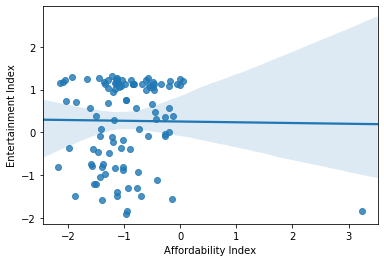

In [404]:
fig = sns.regplot("ratio", "venues", df_tot)
plt.xlabel("Affordability Index")
plt.ylabel("Entertainment Index")
plt.show(fig)

In [407]:
venues_multiplier = 5

df_tot["Result"] = (venues_multiplier * df_tot["venues"] + df_tot["ratio"])/(venues_multiplier + 1)
Result = df_tot.sort_values(by = ["Result"], ascending = False)
Result = Result[Result["group"] != 0]
Result.reset_index(drop = True, inplace = True)
Result["City"].head(20)

0          Houston
1     Philadelphia
2      Minneapolis
3        Nashville
4         Richmond
5          Raleigh
6          Chicago
7        Charlotte
8         Portland
9            Miami
10          Dallas
11      Charleston
12         Madison
13       Baltimore
14          Austin
15            Reno
16          Tucson
17           Tampa
18         Seattle
19        New York
Name: City, dtype: object

## Based on the input information, the best place for me to live is <strong>Houston, TX</strong>.  

The methodology used in this analysis is limited and inherently flawed.  The city with the lowest rating for where to live was San Luis Obispo, CA which almost anyone would move to in a heartbeat.  Overall, I am pleased with the results and I believe they show a relatively good list of the top 20 places to live in the US.  Additional information like crime rate, schools, and specific interests would help this analysis.